In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time
import copy
import calc_vector
import multiprocessing as mp
import random

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse.linalg import spsolve

pd.set_option('display.max_columns', 100)

In [74]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Read Data

In [75]:
path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'

## Amazon Fashion

In [92]:
data_path = 'data/Amazon/'
# file_name = 'Amazon_full' 
# file_name = 'Amazon_05_users' 
# file_name = 'Amazon_01_users'
# file_name = 'Amazon_005_users'
# file_name = 'Amazon_001_users'

## MovieLens

In [ ]:
data_path = 'data/ML/'
# file_name = 'ML_full' 
# file_name = 'ML_05_users'
# file_name = 'ML_01_users'
# file_name = 'ML_005_users'
# file_name = 'ML_001_users'

In [ ]:
df = pd.read_pickle(path + data_path + file_name)
df.head()

# Data Exploration

First filtering active users and rated items with x or more ratings:

---
## Setting rating threshold of 3 and above for a 1

In [67]:
df['user_rating_counts'] = df.groupby('user')['rating'].transform('count')
user_ratings = df.groupby('user')['rating'].count()
item_ratings = df.groupby('item')['rating'].count()
norpu = user_ratings.mean()
norpi = item_ratings.mean()
total_users = df.user.unique().size
total_items = df.item.unique().size
sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))

rows  6598637 
#ratings 6598637 
#ratings/user 13.52 
#ratings/item 17.68 
average rating 4.29 
#users  488200 
#items  373168 
sparse  0.99996 %


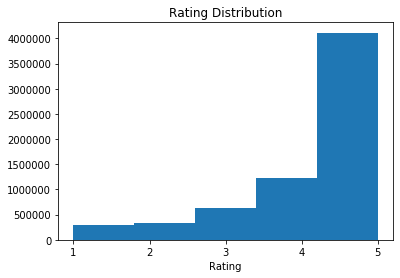

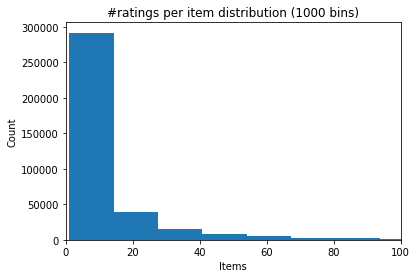

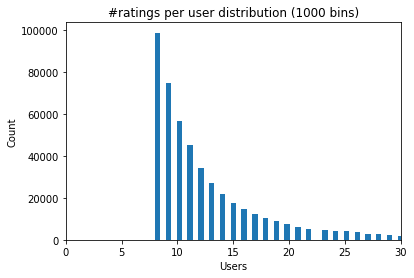

In [68]:
print('rows ', len(df), '\n#ratings', len(df[df['rating'] != 0]), '\n#ratings/user', round(norpu,2), '\n#ratings/item', round(norpi,2), '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), '\n#users ', df['user'].unique().size, '\n#items ', df['item'].unique().size, '\nsparse ', round(sparseness,5), '%')

df.hist(column='rating', bins=5, grid=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.xticks(range(1,6))
plt.savefig('Plots/Deliverables/rating_dist_ml')
plt.show()

plt.hist(item_ratings, bins = 1000)
plt.xlim([0,100])
plt.title('#ratings per item distribution (1000 bins)')
plt.xlabel('Items')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_item_dist_ml')
plt.show()

plt.hist(user_ratings, bins = 1000)
plt.xlim([0,30])
plt.title('#ratings per user distribution (1000 bins)')
plt.xlabel('Users')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_user_dist_ml')
plt.show()

# Data Prep
Create new ids for users and items that match the row and column indices of the user-item interaction matrix

In [48]:
df['item_id'] = df.item.astype('category').cat.codes
df['user_id'] = df.user.astype('category').cat.codes

## Leave item out train test split

In [ ]:
def create_matrices(data, n_users, n_items):
        r = data['user_id']
        c = data['item_id']
        d = data['rating']
        m = sparse.csr_matrix((d, (r, c)), shape=(n_users, n_items))
        m_ones = m.copy()
        m_ones[m_ones > 0] = 1
                               
        return m, m_ones

## Leave users out 

In [37]:
def leave_users_out(full_data, leave_out):
    full_data['index'] = full_data.index
    user_index_df = full_data.groupby('user_id')['index'].apply(list)
    users = np.random.choice(list(user_index_df.index), leave_out, replace=False)
    users_indices = []
    
    for user in users:
        users_indices.extend(user_index_df.loc[user])
    
    sub_set = full_data.loc[users_indices]
    remaining = full_data.drop(users_indices)
    
    return remaining.drop(columns=['index']), sub_set.drop(columns=['index'])

In [ ]:
train_set, test_set = leave_users_out(df_new_ids, 2000)
val_set, test_set = leave_users_out(test_set, 1000)

# Model

## Bayesian Personalized Ranking
- Paper: https://arxiv.org/pdf/1205.2618.pdf
- Code:  https://github.com/valerystrizh/bpr/blob/master/BPR.java

In [ ]:
class BPR():
    def __init__(self, total_users, total_items, params):
        self.total_users = total_users
        self.total_items = total_items
        self.nolf = params['nolf']
        self.n_iterations = params['n_iterations']
        self.alpha = params['alpha']
        self.reg_user = params['reg_user']
        self.reg_item = params['reg_item']
        self.reg_bias = params['reg_bias']
        self.alpha_decay = self.alpha / self.n_iterations
        self.model = {}
        
    def fit(self, train_set, val_set, val_rank):
        #Init
        s = time.time()
        p = np.random.normal(0, .1, (self.total_users, self.nolf))  # users
        q = np.random.normal(0, .1, (self.total_items, self.nolf))  # items
        b_item = np.zeros(self.total_items)
        
        train_ratings, train_ones = self.create_matrices(train_set)
        user_items = train_set.groupby('user_id')['item_id'].apply(list)
        train_users  = train_set.new_user_id.unique()
        train_items = train_set.new_item_id.unique()
        
        loss_list = []
        alphas = []
        val_prec_at = []
        val_rec_at = []
        val_hitcount = []
        
        for iteration in range(self.n_iterations):
            it_loss = 0
            for sample in range(len(train_set)):
                u = int(np.random.choice(train_users))
                u_items = user_items[u]
                i = random.choice(u_items)
                j = int(np.random.choice(train_items)) # neg item
                
                while j in u_items: # j cannot be the same item or an item with a 1
                    j = int(np.random.choice(train_items))

                pos_item_pred = b_item[i] + np.dot(p[u], q[i].T)
                neg_item_pred = b_item[j] + np.dot(p[u], q[j].T)
                diff = pos_item_pred - neg_item_pred

                loss_value = - np.log(self.sigmoid(diff)) #NEGATIVE?
                regulariser = self.reg_user * np.dot(p[u], p[u]) + self.reg_item * np.dot(q[i],q[i]) + self.reg_item/10 * np.dot(q[j], q[j]) + self.reg_bias * (b_item[i]**2 + b_item[j]**2) 
                it_loss += loss_value + regulariser

                diff_deriv = self.sigmoid(- diff)

                for f in range(self.nolf): # update each factor (see notes for derivatives)
                    p[u,f] += self.alpha * (diff_deriv * (q[i,f] - q[j,f]) - self.reg_user * p[u,f])
                    q[i,f] += self.alpha * (diff_deriv * p[u,f] - self.reg_item * q[i,f])
                    q[j,f] += self.alpha * (diff_deriv * (-p[u,f]) - self.reg_item / 10 * q[j,f])
                
#                 b_item[i] += self.alpha * (diff_deriv - self.reg_bias * b_item[i])
#                 b_item[j] += self.alpha * (- diff_deriv - self.reg_bias / 10 * b_item[j])

#                     it_loss += self.reg_user * p[u,f] * p[u,f] + self.reg_item * q[i,f] * q[i,f] + self.reg_item * q[j,f] * q[j,f]
            self.model['p'] = p
            self.model['q'] = q
            self.model['b'] = b_item
#             rec_at, prec_at, hitcount = self.eval(val_set, val_rank)
            print('iteration:', iteration, ' loss:', round(it_loss,2))#, ' val prec@' + str(val_rank), ':', round(prec_at,5), ' val rec@' + str(val_rank), ':', round(rec_at,5), '  Hits:', hitcount)#'  alpha:', self.alpha)
            
            if iteration > 0:
                self.update_alpha(loss_list[-1], it_loss)
                
            alphas.append(self.alpha)
            loss_list.append(it_loss)
#             val_prec_at.append(prec_at)
#             val_rec_at.append(rec_at)
#             val_hitcount.append(hitcount)
        
        t = time.time() - s
        self.model['train_loss'] = loss_list
        self.model['learning_rate'] = alphas
        self.model['train_time'] = t
        self.model['val_prec_at'] = val_prec_at
        self.model['val_rec_at'] = val_rec_at
        self.model['val_hitcount'] = val_hitcount
        
        
    def create_matrices(self, data):
        r = data['new_user_id']
        c = data['new_item_id']
        d = data['rating']
        m = sparse.csr_matrix((d, (r, c)), shape=(self.total_users, self.total_items))
        m_ones = m.copy()
        m_ones[m_ones > 0] = 1                 
        return m, m_ones
    
    def sigmoid(self, x):
        return 1 / (1 + math.exp(-x))
    
    def update_alpha(self, last_loss, it_loss):
        if(last_loss < it_loss): #bold driver
            self.alpha = 0.5 * self.alpha
            return
        
        self.alpha = (1 - self.alpha_decay) * self.alpha
        
    def eval(self, val_set, max_rank):
        import eval_rank
        val_ratings, val_ones = create_matrices(val_set, self.total_users, self.total_items)
        result = self.model
        users = val_set.new_user_id.unique()
        items = val_set.new_item_id.unique()

        s = time.time()
        rank_at = max_rank
        mp_splits = 4
        users_split = np.array_split(users, mp_splits)

        if __name__ == '__main__':
            pool = mp.Pool(processes = mp_splits)
            ranked = pool.map(eval_rank.eval_rank, [[result, users_split[0], items, val_ones, rank_at], 
                                                    [result, users_split[1], items, val_ones, rank_at], 
                                                    [result, users_split[2], items, val_ones, rank_at], 
                                                    [result, users_split[3], items, val_ones, rank_at]])
            pool.close()

            ranked_df = pd.DataFrame()

            for i in range(mp_splits):
                ranked_df = pd.concat([ranked_df, ranked[i]])

            t = time.time() - s
            hitcount = 0
            for u in ranked_df.index:
                hitcount += len(set(ranked_df.loc[u]['true_id']) & set(ranked_df.loc[u]['pred_items_ranked']))

            prec_at =  hitcount / (len(ranked_df) * rank_at)
            rec_at = hitcount / (len(ranked_df) * len(ranked_df.loc[0]['true_id']))
            
            return prec_at, rec_at, hitcount
#             print(t)

# Train Model

## BPR

In [ ]:
params = {
"nolf":20, #Size of latent feature vectors
"n_iterations":20, #around 30 is sufficient
"alpha":0.08, # Learning rate
          
#Regularizers, still tweaking the values
"reg_user":0.1,
"reg_item":0.1,
"reg_bias":0.01
}

In [ ]:
file_name

In [ ]:
model_BPR = BPR(total_users, total_items, params)
model_BPR.fit(train_set, val_set, 20)
results = model_BPR.model

## Store Model

In [ ]:
def store_results(results, log_path, res_name, file_name):
        result_info = {'train_loss': results['train_loss'], 'train_speed': results['train_time'], 'lr':results['learning_rate'], 'file':file_name}
        other_info = {'b': results['b'], 'p':results['p'], 'q':results['q']} #'train_size':train_size, 'test_size':test_size, 'val_size':val_size}
        final_log = dict(result_info, **params, **other_info)

        if not os.path.exists(log_path + res_name):
            df_results = pd.DataFrame(columns=final_log.keys())
            print('new results created')

        else:
            df_results = pd.read_pickle(log_path + res_name)
            print('results added')

        df_results = df_results.append(final_log, ignore_index=True)
        pd.to_pickle(df_results, log_path + res_name)

In [ ]:
log_path = 'Results/BPR/'
res_name = 'all_BPR_res'
store_results(results, log_path, res_name, file_name)

In [ ]:
df_res = pd.read_pickle(log_path + res_name)

In [ ]:
df_res

In [ ]:
last = len(df_res['train_loss']) - 1

In [ ]:
plt.plot(df_res['train_loss'][last])
plt.show()

In [ ]:
plt.plot(df_res['lr'][last])
plt.show()

# Evaluation

In [ ]:
test_ratings, test_ones = create_matrices(test_set, total_users, total_items)

In [ ]:
# test_ratings, test_ones = create_matrices(val_set, total_users, total_items)

In [ ]:
len(test_set.new_user_id.unique())

In [ ]:
import eval_rank
result = {'b':list(df_res['b'])[last], 'p':list(df_res['p'])[last], 'q':list(df_res['q'])[last]}
users = test_set.new_user_id.unique()
items = test_set.new_item_id.unique()

s = time.time()
rank_at = 20
mp_splits = 4
users_split = np.array_split(users, mp_splits)
        
if __name__ == '__main__':
    pool = mp.Pool(processes = mp_splits)
    ranked = pool.map(eval_rank.eval_rank, [[result, users_split[0], items, test_ones, rank_at], 
                                            [result, users_split[1], items, test_ones, rank_at], 
                                            [result, users_split[2], items, test_ones, rank_at], 
                                            [result, users_split[3], items, test_ones, rank_at]])
    pool.close()
    
    ranked_df = pd.DataFrame()

    for i in range(mp_splits):
        ranked_df = pd.concat([ranked_df, ranked[i]])
        
    t = time.time() - s
    print(t/60)

## Metrics

In [ ]:
steps = 5
ranks_at = [1] + [i for i in range(steps, rank_at + steps, steps)]

In [ ]:
ranks_at

In [ ]:
hitcounts = []
recs_at = []
precs_at = []
for rank in ranks_at:
    hitcount = 0
    for u in ranked_df.index:
        hitcount +=  len(set(ranked_df.loc[u]['true_id'][0]) & set(ranked_df.loc[u]['pred_items_ranked'][:rank]))
                    
    prec_at = hitcount / rank / len(ranked_df)
    rec_at = hitcount / len(ranked_df.loc[0]['true_id']) / len(ranked_df)
    
    print('rank_at:', rank, '  Hits:', hitcount)
    hitcounts.append(hitcount)                     
    recs_at.append(rec_at)
    precs_at.append(prec_at)

In [ ]:
# rank_at: 1   Hits: 1185
# rank_at: 5   Hits: 4218
# rank_at: 10   Hits: 7687
# rank_at: 15   Hits: 11209
# rank_at: 20   Hits: 14630

# 2m-ml without bias
# rank_at: 1   Hits: 120
# rank_at: 5   Hits: 1022
# rank_at: 10   Hits: 2101
# rank_at: 15   Hits: 3150
# rank_at: 20   Hits: 4152

# 2m-ml with bias
# rank_at: 1   Hits: 207
# rank_at: 5   Hits: 1114
# rank_at: 10   Hits: 2365
# rank_at: 15   Hits: 3647
# rank_at: 20   Hits: 4653

In [ ]:
bpr_results = pd.read_pickle('Results/BPR/bpr_hitcounts')
bpr_results

In [ ]:
hitcounts

In [ ]:
bpr_results[file_name] = hitcounts

In [ ]:
bpr_results.to_pickle('Results/BPR/bpr_hitcounts')

In [ ]:
bpr_results

In [ ]:
# rank_at: 1   Hits: 176
# rank_at: 5   Hits: 1103
# rank_at: 10   Hits: 2296
# rank_at: 15   Hits: 3453
# rank_at: 20   Hits: 4655

In [ ]:
hitcounts

In [ ]:
precs_at

In [ ]:
recs_at

## Test Data

In [ ]:
plt.plot(ranks_at, precs_at)
plt.xlabel('Rank')
plt.ylabel('precision@')
plt.title('Precision for different rank values')
plt.show()

In [ ]:
plt.plot(ranks_at, recs_at)
plt.xlabel('Rank')
plt.ylabel('recall@')
plt.title('Recall for different rank values (1 item/user)')
plt.show()

## Val Data

In [ ]:
plt.plot(ranks_at, precs_at)
plt.xlabel('Rank')
plt.ylabel('precision@')
plt.title('Precision for different rank values')
plt.show()

In [ ]:
plt.plot(ranks_at, recs_at)
plt.xlabel('Rank')
plt.ylabel('recall@')
plt.title('Recall')
plt.show()

In [ ]:
ranked_df.to_pickle('Results/BPR/ranked' + file_name)

In [ ]:
ranked_df = pd.read_pickle('Results/BPR/ranked_ML_0.7m')

# Appendix

In [ ]:
# df = pd.read_pickle('Data/amazon_clothing_shoes_jewelry_data')
# users = df.user.unique()
# to_keep = users[:300000]

# user_indices = df.groupby('user')['index'].apply(list)
# to_keep_indices = []
# for u in user_indices[to_keep]:
#     to_keep_indices.extend(u)

# new_df = df_og.loc[to_keep_indices]
# len(to_keep_indices)

## standard SVD model

In [ ]:
class SVD:
    """" All functions used to run, test, plot and store the
    Singular Value Decomposition Model"""

    def __init__(self, params, total_users, total_items):
        self.nolf = params['nolf']
        self.n_epochs = params['n_epochs']
        self.alpha = params['alpha']
        self.alpha_b = params['alpha_b']
        self.alpha_cb = params['alpha_cb']
        self.use_bias = params['use_bias']
        self.use_impl_fb = params['use_impl_fb']
        self.use_color = params['use_color']
        self.use_weight_ver = params['use_weight_ver']
        self.bu_reg = params['bu_reg']
        self.bi_reg = params['bi_reg']
        self.pu_reg = params['pu_reg']
        self.qi_reg = params['qi_reg']
        self.x_reg = params['x_reg']
        self.cb_reg = params['cb_reg']
        self.ver_weight = params['ver_weight']
        self.stop = params['stop']
        self.random_state = params['random_state']
        self.total_users = total_users
        self.total_items = total_items
        self.params = params
        self.mu = 0 
        self.N = []
        self.N_test = []
        self.t = pd.DataFrame()
        self.c = pd.DataFrame()
        self.F = pd.DataFrame()

        self.train_data = pd.DataFrame()
        self.test_data = pd.DataFrame()
        self.val_data = pd.DataFrame()
        self.train_time = 0
        self.best_model = {}
        self.model = {}
        self.test_results = {}

    def fit(self, train_data, val_data=[], verbose=1, plot=True, plot_name=''):
        self.train_data = train_data
        self.val_data = val_data
        self.SVD(train_data=train_data, val_data=val_data, verbose=verbose, plot=plot, plot_name=plot_name)
        return self

    
###############################################################################################
    
    def SVD(self, train_data, val_data, verbose, plot, plot_name):
        """"The SVD algorithm with sgd
        input: rating dataset with columns:['rating', 'user_id', 'item_id']
        output: the resulting p, q, bi, bu matrices"""
        self.mu = self.create_mu(train_data)
        train_matrix = self.create_matrix(train_data, self.total_users, self.total_items)
        
        tuples_train = [tuple(x) for x in train_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        
        p = np.random.normal(0, .1, (total_users, self.nolf))  # users
        q = np.random.normal(0, .1, (total_items, self.nolf))  # items
        
        # user and item biases
        b_user = np.zeros(total_users)
        b_item = np.zeros(total_items)
        
        # using color (pareto split (0,1,2)) attribute bias
        if self.use_color:
            print('Creating F and c, for incorporating color bias')
            self.F, self.c = self.init_color(train_data)

        # implicit fb rated, not rated
        x = np.random.normal(0, .1, (total_items, self.nolf))
        impl_fb_u = np.zeros(self.nolf)
        if self.use_impl_fb:
            print('Creating N, for incorporating implicit feedback')
            self.N = train_data.groupby('new_user_id')['new_item_id'].apply(list)
        
        # 0.5 weight on the errors of verified = False user item combinations
        if self.use_weight_ver:
            i_verified = train_data.set_index(['new_user_id', 'new_item_id'])['verified']
            i_verified = i_verified.loc[~i_verified.index.duplicated(keep='first')]
        
        sqrt_Nu = 0
        cb = 0
        rmses = []
        val_rmses = []
        smallest_val_rmse = 10000
        val_rmse = "na"
        start = time.time()
        for epoch in range(self.n_epochs):
            total_sq_error = 0
            for u, i, r_ui in tuples_train:
                u = int(u)
                i = int(i)
                
                if self.use_impl_fb:
                    impl_fb_u = np.zeros(self.nolf)
                    sqrt_Nu = np.sqrt(len(self.N[u]))
                    for j in self.N[u]:
                        impl_fb_u += x[j] / sqrt_Nu

                if self.use_color and epoch > 5:
                    F_ui =  self.F[u,i] #Set of items associated with i and rated by u
                    u_mu = self.mu + b_user[u]
                    sqrt_F_ui = np.sqrt(len(F_ui))
                    for index, f in enumerate(F_ui):
                        r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
                        cb += (r_uf - u_mu) * self.c[u,i][index]
                    cb /=  sqrt_F_ui
                        
                if self.use_bias:   
                    error = r_ui - ((self.mu + b_user[u] + b_item[i] + cb) + np.dot(p[u] + impl_fb_u, q[i]))
                    if self.use_weight_ver and not i_verified[u,i]:
                        error = self.ver_weight * error
                    
                    b_user[u] += self.alpha_b * (error - self.bu_reg * b_user[u])
                    b_item[i] += self.alpha_b * (error - self.bi_reg * b_item[i])
                else:
                    error = r_ui - np.dot(p[u], q[i])

                p[u] += self.alpha * (error * q[i] - self.pu_reg * p[u])
                q[i] += self.alpha * (error * (p[u] + impl_fb_u) - self.qi_reg * q[i])
                total_sq_error += np.square(error)
            
                if self.use_impl_fb:
                    for j in self.N[u]:
                        x[j] += self.alpha * (error * q[i] / sqrt_Nu - self.x_reg * x[j])
                
                if self.use_color and epoch > 5:
                    for index, f in enumerate(F_ui):
                        r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
                        u_mu = self.mu + b_user[u]
                        self.c[u,i][index] += self.alpha_cb * (error * (1/sqrt_F_ui) * (r_uf - u_mu) - self.cb_reg * self.c[u,i][index])
                
            rmse = np.sqrt(total_sq_error / len(tuples_train))
            rmses.append(rmse)
            
            self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
            
            # Validation
            if len(val_data) > 0:
                new_val_rmse = self.test(val_data, val=True)
                val_rmses.append(new_val_rmse)
                if new_val_rmse < smallest_val_rmse:
                    smallest_val_rmse = new_val_rmse
                    self.best_model = copy.deepcopy(self.model)
                val_rmse = new_val_rmse
                
            # Epoch Printing
            if epoch % verbose == 0:
                if len(val_data) > 0:
                    print('Epoch:', epoch, '  RMSE:', rmse, ' Val_RMSE:', val_rmse)
                else:
                    print('Epoch:', epoch, '  RMSE:', rmse)
            
            if self.stop and val_rmses[-2:][0] < val_rmse:
                print('BREAK: Validation set not improving anymore')
                break
                
        if plot:
            self.plot_rmse(rmses, val_rmses, plot_name)

        self.train_time = time.time() - start
        self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
#################################################################################################

    def init_color(self, data_set):
        self.t = data_set.groupby(['new_user_id', 'par_col2'])['new_item_id'].apply(list)
        F = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items)
        c = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items, random=True)
        return F, c

    def sim_items(self, x, random=False):
        u_id = x.name[0]
        col = x.iloc[0]
        if random:
            return np.random.normal(0,.1,len(self.t[u_id, col]))
        return self.t[u_id, col]
    
    def create_matrix(self, X_train, n_users, n_items):
        r = X_train['new_user_id']
        c = X_train['new_item_id']
        d = X_train['rating']
        train_matrix = sparse.coo_matrix((d, (r, c)), shape=(n_users, n_items))
    
        return train_matrix.tocsr()
    
    def create_mu(self, train_set):
        # Better mean calculation according to https://sifter.org/~simon/journal/20061211.html
        va = train_set.groupby('new_user_id')['rating'].mean().var() #variance mean ratings users
        vb = train_set.groupby('new_item_id')['rating'].mean().var() #variance mean ratings items
        k = va/vb #variance proportion
        better_mu = (train_set['rating'].mean() + train_set['rating'].sum()) / (k+len(train_set))
        return better_mu
    
    def plot_rmse(self, rmse, val_rmses=[], plot_name=''):
        plt.plot(np.arange(len(rmse)), rmse)
        if len(val_rmses) > 0:
            plt.plot(np.arange(len(val_rmses)), val_rmses, color='red')
        plt.title('RMSE')
        plt.xlabel('epoch')
        plt.ylabel('RMSE')
        plt.legend(['Train', 'Validation'])
        if len(plot_name) > 0:
            plt.savefig('Plots/' + plot_name + '.png')
        plt.show()

    def test(self, test_data, val=False):
        if not val:
            self.test_data = test_data
        tuples_test = [tuple(x) for x in test_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        test_matrix = self.create_matrix(test_data, self.total_users, self.total_items)
        
        if self.use_impl_fb and val:
            self.N_test = self.val_data.groupby('new_user_id')['new_item_id'].apply(list)
        elif self.use_impl_fb:
            self.N_test = self.test_data.groupby('new_user_id')['new_item_id'].apply(list)
            
        total_error = 0
        estimates = []
        for u, i, r_ui in tuples_test:
            u = int(u)
            i = int(i)
            est = self.estimate(u, i, test_matrix, test_data)
            estimates.append(est)
            total_error += np.square(r_ui - est)
        
        rmse = np.sqrt(total_error / len(tuples_test))
        
        if not val:
            self.test_results = {'rmse': rmse, 'estimates':estimates}
            print('RMSE on test set:', self.test_results['rmse'])
        else:
            return rmse

    def estimate(self, u, i, test_matrix, test_data):
        est = self.mu + self.model['bu'][u] + self.model['bi'][i]
        impl_fb_u = np.zeros(self.nolf)
        cb = 0
        if u in self.train_data['new_user_id'] and i in self.train_data['new_item_id']:
            
            if self.use_impl_fb and u in self.N.index:
                sqrt_Nu = np.sqrt(len(self.N[u]))
                for j in self.N[u]:   
                    impl_fb_u += self.model['x'][j] / sqrt_Nu
            
            if self.use_color and (u,i) in self.model['cbu']:
                F_ui =  self.F[u,i] #Set of items associated with i and rated by u
                u_mu = self.mu + self.model['bu'][u]
                sqrt_F_ui = np.sqrt(len(F_ui))
                for index, f in enumerate(F_ui):
                    r_uf = self.train_data[(self.train_data['new_user_id']==u) & (self.train_data['new_item_id']==f)]['rating'].iloc[0]
                    cb += (r_uf - u_mu) * self.model['cbu'][u,i][index]
                cb /=  sqrt_F_ui
                
            est += cb + np.dot(self.model['p'][u] + impl_fb_u, self.model['q'][i])

        return est
    
    def store_results(self, log_path, res_name, user_thres, item_thres):
        train_size = round((len(self.train_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        test_size = round((len(self.test_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        val_size = round((len(self.val_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        
        result_info = {'RMSE_test': self.test_results['rmse'], 'train_speed': round(self.train_time,2)}
        other_info = {'u_thres': user_thres,'i_thres': item_thres, 'train_size':train_size, 'test_size':test_size, 'val_size':val_size, 'train_rmse':self.model['rmse'], 'val_rmse':self.model['val_rmse']}
        final_log = dict(result_info, **self.params, **other_info)

        if not os.path.exists(log_path + res_name):
            df_results = pd.DataFrame(columns=final_log.keys())
            print('new results created')

        else:
            df_results = pd.read_pickle(log_path + res_name)
            print('results added')

        df_results = df_results.append(final_log, ignore_index=True)
        pd.to_pickle(df_results, log_path + res_name)

In [ ]:
class BPR():
    def __init__(self, total_users, total_items, params):
        self.total_users = total_users
        self.total_items = total_items
        self.nolf = params['nolf']
        self.n_iterations = params['n_iterations']
        self.alpha = params['alpha']
        self.reg_user = params['reg_user']
        self.reg_item = params['reg_item']
        self.reg_bias = params['reg_bias']
        self.alpha_decay = self.alpha / self.n_iterations
        self.model = {'loss_list':[], 'learning_rate':[]}
        
    def fit(self, train_set, val_set, val_rank, batch_size=1000):
        #Init
        s = time.time()
        self.model['p'] = np.random.normal(0, .1, (self.total_users, self.nolf))  # users
        self.model['q'] = np.random.normal(0, .1, (self.total_items, self.nolf))  # items
        self.model['b'] = np.zeros(self.total_items)
        
#         val_prec_at = []
#         val_rec_at = []
#         val_hitcount = []
        
        # Create samples 
        n_sgd_samples = len(train_set) * self.n_iterations
        
        z = 0
        self.model['train_time'] = 0
        print('init and sampling done:', time.time() - s, 'seconds')
        for i in range(self.n_iterations):
            sgd_users, sgd_pos_items, sgd_neg_items = self.user_sampling(train_set, n_sgd_samples)
        
        while (z+1)*batch_size < n_sgd_samples:
            s_it = time.time()
            it_loss = self.train(sgd_users[z*batch_size:(z+1)*batch_size], sgd_pos_items[z*batch_size:(z+1)*batch_size], sgd_neg_items[z*batch_size:(z+1)*batch_size])
            
            if z > 0:
                self.update_alpha(it_loss)
            
            z += 1
            self.model['loss_list'].append(it_loss) 

#             rec_at, prec_at, hitcount = self.eval(val_set, val_rank)
            t_it = time.time()- s_it
            self.model['train_time'] += t_it
            print('batch:', z, ' loss:', round(it_loss,4), 'iteration time:', round(t_it/2,2))#, ' val prec@' + str(val_rank), ':', round(prec_at,5), ' val rec@' + str(val_rank), ':', round(rec_at,5), '  Hits:', hitcount)#'  alpha:', self.alpha)
    
#             val_prec_at.append(prec_at)
#             val_rec_at.append(rec_at)
#             val_hitcount.append(hitcount)
            
#         self.model['val_prec_at'] = val_prec_at
#         self.model['val_rec_at'] = val_rec_at
#         self.model['val_hitcount'] = val_hitcount
        
        
    def create_matrices(self, data):
        r = data['new_user_id']
        c = data['new_item_id']
        d = data['rating']
        m = sparse.csr_matrix((d, (r, c)), shape=(self.total_users, self.total_items))
        m_ones = m.copy()
        m_ones[m_ones > 0] = 1                 
        return m, m_ones
    
    def sigmoid(self, x):
        return 1 / (1 + math.exp(-x))
    
    def user_sampling(self, data, n_samples):
        train_ratings, train_ones = self.create_matrices(train_set)
        user_items = train_set.groupby('new_user_id')['new_item_id'].apply(list)
        train_users  = train_set.new_user_id.unique()
        train_items = train_set.new_item_id.unique()
        
        sgd_users, sgd_pos_items, sgd_neg_items = [], [], []
        for sample in range(n_samples):
            u = np.random.choice(train_users)
            i = random.choice(user_items[u])

            j = int(np.random.choice(train_items)) # neg item
#             j_v = int(train_ones[u,j]) # Value, NEEDED?

            while j in user_items[u]: # j cannot be the same item or an item with a 1
                j = int(np.random.choice(train_items))
#                 j_v = int(train_ones[u,j])
            
            sgd_users.append(u)
            sgd_pos_items.append(i)
            sgd_neg_items.append(j)
            
        return sgd_users, sgd_pos_items, sgd_neg_items
        
    def train(self, users, pos_items, neg_items):
        for u, i, j in zip(users, pos_items, neg_items):
            pos_item_pred = self.model['b'][i] + np.dot(self.model['p'][u], self.model['q'][i].T)
            neg_item_pred = self.model['b'][j] + np.dot(self.model['p'][u], self.model['q'][j].T)
            diff = pos_item_pred - neg_item_pred

            loss_value = - np.log(self.sigmoid(diff)) #NEGATIVE?
            regulariser = self.reg_user * np.dot(self.model['p'][u], self.model['p'][u]) + self.reg_item * np.dot(self.model['q'][i],self.model['q'][i]) + self.reg_item/10 * np.dot(self.model['q'][j], self.model['q'][j]) + self.reg_bias * (self.model['b'][i]**2 + self.model['b'][j]**2) 
            it_loss = loss_value + regulariser

            diff_deriv = self.sigmoid(- diff)
            
            #SGD update
            for f in range(self.nolf): # update each factor (see notes for derivatives)
                self.model['p'][u,f] += self.alpha * (diff_deriv * (self.model['q'][i,f] - self.model['q'][j,f]) - self.reg_user * self.model['p'][u,f])
                self.model['q'][i,f] += self.alpha * (diff_deriv * self.model['p'][u,f] - self.reg_item * self.model['q'][i,f])
                self.model['q'][j,f] += self.alpha * (diff_deriv * (-self.model['p'][u,f]) - self.reg_item / 10 * self.model['q'][j,f])
                self.model['b'][i] += self.alpha * (diff_deriv * self.reg_bias * self.model['b'][i])
                self.model['b'][j] += self.alpha * (- diff_deriv * (- self.reg_bias) * self.model['b'][j])

#                 it_loss += self.reg_user * self.model['p'][u,f] * self.model['p'][u,f] + self.reg_item * self.model['q'][i,f] * self.model['q'][i,f] + self.reg_item * self.model['q'][j,f] * self.model['q'][j,f]
        return it_loss
        
    def update_alpha(self, it_loss):
        last_loss = self.model['loss_list'][-1]
        if(last_loss < it_loss): #bold driver
            self.alpha = 0.5 * self.alpha
            return
        
        self.alpha = (1 - self.alpha_decay) * self.alpha
        self.model['learning_rate'].append(self.alpha)
        
    def eval(self, val_set, max_rank):
        import eval_rank
        val_ratings, val_ones = create_matrices(val_set, self.total_users, self.total_items)
        result = self.model
        users = val_set.new_user_id.unique()
        items = val_set.new_item_id.unique()

        s = time.time()
        rank_at = max_rank
        mp_splits = 4
        users_split = np.array_split(users, mp_splits)

        if __name__ == '__main__':
            pool = mp.Pool(processes = mp_splits)
            ranked = pool.map(eval_rank.eval_rank, [[result, users_split[0], items, val_ones, rank_at], 
                                                    [result, users_split[1], items, val_ones, rank_at], 
                                                    [result, users_split[2], items, val_ones, rank_at], 
                                                    [result, users_split[3], items, val_ones, rank_at]])
            pool.close()

            ranked_df = pd.DataFrame()

            for i in range(mp_splits):
                ranked_df = pd.concat([ranked_df, ranked[i]])

            t = time.time() - s
            hitcount = 0
            for u in ranked_df.index:
                hitcount += len(set(ranked_df.loc[u]['true_id']) & set(ranked_df.loc[u]['pred_items_ranked']))

            prec_at =  hitcount / (len(ranked_df) * rank_at)
            rec_at = hitcount / (len(ranked_df) * len(ranked_df.loc[0]['true_id']))
            
            return prec_at, rec_at, hitcount
#             print(t)